In [1]:
from scipy.io import loadmat
import pandas as pd
import numpy as np
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
import math
import pickle

In [2]:
from google.cloud import storage

storage_client = storage.Client()
bucket_name = 'cloud-ai-platform-a56f8fcc-e932-4620-aba0-5c45ad1e9911'
dataset_path1 = "yellow_tripdata_2023-01.parquet"
dataset_path2 = "yellow_tripdata_2023-02.parquet"
bucket = storage_client.bucket(bucket_name)
blob1 = bucket.blob(dataset_path1)
blob2 = bucket.blob(dataset_path2)
#local_dataset_path1 = 'url1.mat'
blob1.download_to_filename(dataset_path1)
blob2.download_to_filename(dataset_path2)

In [3]:
df = pd.read_parquet('yellow_tripdata_2023-01.parquet')
print(df.shape)
df['duration'] = df.tpep_dropoff_datetime - df.tpep_pickup_datetime
df.duration = df.duration.apply(lambda td: td.total_seconds() / 60)


(3066766, 19)


In [4]:
df.duration.std()

42.59435124195458

In [5]:
df1 = df[(df.duration >= 1) & (df.duration <= 60)]
df1

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee,duration
0,2,2023-01-01 00:32:10,2023-01-01 00:40:36,1.0,0.97,1.0,N,161,141,2,9.30,1.00,0.5,0.00,0.0,1.0,14.30,2.5,0.00,8.433333
1,2,2023-01-01 00:55:08,2023-01-01 01:01:27,1.0,1.10,1.0,N,43,237,1,7.90,1.00,0.5,4.00,0.0,1.0,16.90,2.5,0.00,6.316667
2,2,2023-01-01 00:25:04,2023-01-01 00:37:49,1.0,2.51,1.0,N,48,238,1,14.90,1.00,0.5,15.00,0.0,1.0,34.90,2.5,0.00,12.750000
3,1,2023-01-01 00:03:48,2023-01-01 00:13:25,0.0,1.90,1.0,N,138,7,1,12.10,7.25,0.5,0.00,0.0,1.0,20.85,0.0,1.25,9.616667
4,2,2023-01-01 00:10:29,2023-01-01 00:21:19,1.0,1.43,1.0,N,107,79,1,11.40,1.00,0.5,3.28,0.0,1.0,19.68,2.5,0.00,10.833333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3066761,2,2023-01-31 23:58:34,2023-02-01 00:12:33,NaN,3.05,NaN,None,107,48,0,15.80,0.00,0.5,3.96,0.0,1.0,23.76,NaN,NaN,13.983333
3066762,2,2023-01-31 23:31:09,2023-01-31 23:50:36,NaN,5.80,NaN,None,112,75,0,22.43,0.00,0.5,2.64,0.0,1.0,29.07,NaN,NaN,19.450000
3066763,2,2023-01-31 23:01:05,2023-01-31 23:25:36,NaN,4.67,NaN,None,114,239,0,17.61,0.00,0.5,5.32,0.0,1.0,26.93,NaN,NaN,24.516667
3066764,2,2023-01-31 23:40:00,2023-01-31 23:53:00,NaN,3.15,NaN,None,230,79,0,18.15,0.00,0.5,4.43,0.0,1.0,26.58,NaN,NaN,13.000000


In [6]:
fraction_dropped = ((df.shape[0] -df1.shape[0])/df.shape[0]) * 100
fraction_left = 100 - fraction_dropped
fraction_left

98.1220282212598

In [7]:
categorical = ['PULocationID', 'DOLocationID']
numerical = ['trip_distance']

df[categorical] = df[categorical].astype(str)

In [8]:
train_dicts = df[categorical + numerical].to_dict(orient='records')

dv = DictVectorizer()
X_train = dv.fit_transform(train_dicts)

target = 'duration'
y_train = df[target].values



In [9]:
X_train.shape

(3066766, 519)

In [10]:
lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_train)

mse = mean_squared_error(y_train, y_pred, squared=False)
mse

/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


42.01201352674263

In [11]:
RMSE = math.sqrt(mse)
print("RMSE :", RMSE )

RMSE : 6.481667495848782


/var/tmp/ipykernel_18114/1672306066.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y_pred, label='prediction')
/var/tmp/ipykernel_18114/1672306066.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y_train, label='actual')


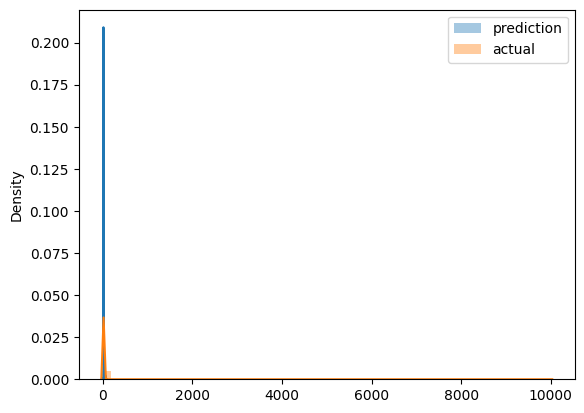

In [12]:
sns.distplot(y_pred, label='prediction')
sns.distplot(y_train, label='actual')

plt.legend()

In [13]:
def read_dataframe(filename):
    if filename.endswith('.csv'):
        df = pd.read_csv(filename)

        df.lpep_dropoff_datetime = pd.to_datetime(df.lpep_dropoff_datetime)
        df.lpep_pickup_datetime = pd.to_datetime(df.lpep_pickup_datetime)
    elif filename.endswith('.parquet'):
        df = pd.read_parquet(filename)

    df['duration'] = df.tpep_dropoff_datetime - df.tpep_pickup_datetime
    df.duration = df.duration.apply(lambda td: td.total_seconds() / 60)

    df = df[(df.duration >= 1) & (df.duration <= 60)]

    categorical = ['PULocationID', 'DOLocationID']
    df[categorical] = df[categorical].astype(str)
    
    return df

In [14]:
df_train = read_dataframe('yellow_tripdata_2023-01.parquet')
df_val = read_dataframe('yellow_tripdata_2023-02.parquet')

In [15]:
len(df_train), len(df_val)

(3009173, 2855951)

In [16]:
df_train['PU_DO'] = df_train['PULocationID'] + '_' + df_train['DOLocationID']
df_val['PU_DO'] = df_val['PULocationID'] + '_' + df_val['DOLocationID']

In [17]:
categorical = ['PU_DO'] #'PULocationID', 'DOLocationID']
numerical = ['trip_distance']

dv = DictVectorizer()

train_dicts = df_train[categorical + numerical].to_dict(orient='records')
X_train = dv.fit_transform(train_dicts)

val_dicts = df_val[categorical + numerical].to_dict(orient='records')
X_val = dv.transform(val_dicts)

In [18]:
target = 'duration'
y_train = df_train[target].values
y_val = df_val[target].values

In [19]:
lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_val)

mse = mean_squared_error(y_val, y_pred, squared=False)

/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [20]:
RMSE = math.sqrt(mse)
print("RMSE :", RMSE )

RMSE : 2.2926354115921996


In [21]:
with open('lin_reg.bin', 'wb') as f_out:
    pickle.dump((dv, lr), f_out)